# Matthew Altaie's Capstone - Final model and testing

## Introduction

In this notebook, I will use KNN imputation to fill in the NaNs. However, I will not be using all features, and will only be using the features with the highest correlation with the target variable (hospital_death). This should cut down processing time and improve any overfitting of the data. Before fitting the models, i will perform undersampling and SMOTE to see if the performance can be improved in comparison with models from older notebooks.The models are:

- Logistic Regression
- KNN Classifier
- Support Vector Classifier
- Gaussian Naive Bayes Classifier
- Random Forest Classifier
- Gradient Boosting Classifier
- XGBoost
- Scikit-learn's Bagging Classifier
- Scikit-learn's Boosting Classifier
- Scikit-learn's Stacking Classifier

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

import xgboost as xgb

from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import collections


%matplotlib inline

#### Importing data

In [2]:
hospital_test_csv = r'C:\Users\matta\Downloads\Data\hospital_test.csv'
hospital_test = pd.read_csv(hospital_test_csv)
hospital_train_csv = r'C:\Users\matta\Downloads\Data\hospital_train.csv'
hospital_train = pd.read_csv(hospital_train_csv)

In [3]:
hospital_train.shape

(91713, 186)

In [4]:
hospital_test.shape

(39308, 186)

In [5]:
hospital_train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [6]:
hospital_test.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


**Note**: hospital_death is the target variable

#### Convert gender to binary

In [7]:
hospital_train['gender'] = hospital_train['gender'].map({'M': 1, 'F': 0})
hospital_test['gender'] = hospital_test['gender'].map({'M': 1, 'F': 0})

In [8]:
hospital_train.info

<bound method DataFrame.info of        encounter_id  patient_id  hospital_id  hospital_death   age        bmi  \
0             66154       25312          118               0  68.0  22.730000   
1            114252       59342           81               0  77.0  27.420000   
2            119783       50777          118               0  25.0  31.950000   
3             79267       46918          118               0  81.0  22.640000   
4             92056       34377           33               0  19.0        NaN   
...             ...         ...          ...             ...   ...        ...   
91708         91592       78108           30               0  75.0  23.060250   
91709         66119       13486          121               0  56.0  47.179671   
91710          8981       58179          195               0  48.0  27.236914   
91711         33776      120598           66               0   NaN  23.297481   
91712          1671       53612          104               0  82.0  22.031250

In [9]:
hospital_train.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,gender,height,icu_id,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,91688.000000,90379.000000,91713.000000,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,0.539536,169.641588,508.357692,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,0.498437,10.795378,228.989661,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,0.000000,137.200000,82.000000,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,0.000000,162.500000,369.000000,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,1.000000,170.100000,504.000000,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,1.000000,177.800000,679.000000,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,1.000000,195.590000,927.000000,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
hospital_train['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [11]:
hospital_train['hospital_death'].value_counts(normalize=True)

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

Baseline accuracy is **91.3%**

#### Dropping irrelevant columns

In [12]:
hospital_train.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [13]:
hospital_train.shape

(91713, 186)

In [14]:
hospital_train = hospital_train.drop(['hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'ethnicity', 'height', 'encounter_id', 'patient_id', 'hospital_id', 'apache_3j_bodysystem', 'apache_2_bodysystem'], axis = 1) # consider these , 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'.

**Note**: may need to reverse the bodysystem change here

In [15]:
hospital_train.shape

(91713, 174)

In [16]:
hospital_test = hospital_test.drop(['hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'ethnicity', 'height', 'encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'apache_3j_bodysystem', 'apache_2_bodysystem'], axis = 1) #consider these , 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'

In [17]:
hospital_test.shape

(39308, 173)

**note**: The difference in shapes comes from the removal of the empty hospital_death feature from the test set

#### Correlation

In [18]:
corr = hospital_train.corrwith(hospital_train['hospital_death'], axis = 0) #This shows the correlation of the diagnosis columns with other columns
corr

hospital_death                 1.000000
age                            0.111017
bmi                           -0.031247
elective_surgery              -0.093574
gender                        -0.007024
                                 ...   
hepatic_failure                0.038864
immunosuppression              0.043973
leukemia                       0.029788
lymphoma                       0.018722
solid_tumor_with_metastasis    0.051105
Length: 174, dtype: float64

In [19]:
corr_short = corr[(corr != 1.0)&((corr > 0.2)|(corr < -0.2))] #I set my threshold for good correlation for correlation >0.25 and <-0.25
corr_short #this is a list of all the variables I will be using for my predictor variables

fio2_apache                      0.212249
gcs_eyes_apache                 -0.260373
gcs_motor_apache                -0.282449
gcs_verbal_apache               -0.241044
ph_apache                       -0.205075
ventilated_apache                0.228661
d1_mbp_invasive_min             -0.222350
d1_spo2_min                     -0.210100
d1_sysbp_invasive_min           -0.234382
d1_sysbp_min                    -0.210170
d1_sysbp_noninvasive_min        -0.209926
d1_temp_min                     -0.207239
d1_albumin_min                  -0.200590
d1_lactate_max                   0.399029
d1_lactate_min                   0.403614
h1_albumin_max                  -0.224928
h1_albumin_min                  -0.225402
h1_lactate_max                   0.340951
h1_lactate_min                   0.344046
d1_arterial_ph_min              -0.230365
h1_arterial_ph_max              -0.207716
apache_4a_hospital_death_prob    0.311043
apache_4a_icu_death_prob         0.283913
dtype: float64

The above features are the ones with the highest correlation to the hopsital_death target variable

#### Checking null values and dealing with null values

In [20]:
nulls = hospital_train.isnull().sum().to_frame('nulls')   #check for null

In [21]:
nulls

,nulls
hospital_death,0
age,4228
bmi,3429
elective_surgery,0
gender,25
...,...
hepatic_failure,715
immunosuppression,715
leukemia,715
lymphoma,715


In [22]:
print(nulls.to_markdown())

|                               |   nulls |
|:------------------------------|--------:|
| hospital_death                |       0 |
| age                           |    4228 |
| bmi                           |    3429 |
| elective_surgery              |       0 |
| gender                        |      25 |
| pre_icu_los_days              |       0 |
| readmission_status            |       0 |
| weight                        |    2720 |
| albumin_apache                |   54379 |
| apache_2_diagnosis            |    1662 |
| apache_3j_diagnosis           |    1101 |
| apache_post_operative         |       0 |
| arf_apache                    |     715 |
| bilirubin_apache              |   58134 |
| bun_apache                    |   19262 |
| creatinine_apache             |   18853 |
| fio2_apache                   |   70868 |
| gcs_eyes_apache               |    1901 |
| gcs_motor_apache              |    1901 |
| gcs_unable_apache             |    1037 |
| gcs_verbal_apache             

**Note**: There are a LOT of columns with massive amounts of missing data. The code below will remove any columns with a set percentage of null values missing:

thresh = len(df) * .2<br>
df.dropna(thresh = thresh, axis = 1, inplace = True)

This is taken from: https://stackoverflow.com/questions/46939314/drop-columns-in-a-pandas-dataframe-based-on-the-of-null-values <br>
The function below is also from the same link above, which calculates how much percent of a column is null values

In [23]:
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns

In [24]:
h = missing_values_table(hospital_train)

In [25]:
print(h.to_markdown())

|                               |   Missing Values |   % of Total Values |
|:------------------------------|-----------------:|--------------------:|
| hospital_death                |                0 |           0         |
| age                           |             4228 |           4.61003   |
| bmi                           |             3429 |           3.73884   |
| elective_surgery              |                0 |           0         |
| gender                        |               25 |           0.0272589 |
| pre_icu_los_days              |                0 |           0         |
| readmission_status            |                0 |           0         |
| weight                        |             2720 |           2.96577   |
| albumin_apache                |            54379 |          59.2926    |
| apache_2_diagnosis            |             1662 |           1.81217   |
| apache_3j_diagnosis           |             1101 |           1.20048   |
| apache_post_operative  

In [26]:
h2 = missing_values_table(hospital_test)
print(h2.to_markdown())

|                               |   Missing Values |   % of Total Values |
|:------------------------------|-----------------:|--------------------:|
| age                           |             1654 |           4.20779   |
| bmi                           |             1086 |           2.7628    |
| elective_surgery              |                0 |           0         |
| gender                        |               15 |           0.0381602 |
| pre_icu_los_days              |                0 |           0         |
| readmission_status            |                0 |           0         |
| weight                        |              764 |           1.94362   |
| albumin_apache                |            24650 |          62.7099    |
| apache_2_diagnosis            |              896 |           2.27943   |
| apache_3j_diagnosis           |              637 |           1.62054   |
| apache_post_operative         |                0 |           0         |
| arf_apache             

In [27]:
hospital_train.shape

(91713, 174)

**Note**: After going through many variations, I found that it is best to use a cut off threshold of 50%. That is, if a column has more than 50% NaN, it will be dropped. Also, Dropping ALL NaN values will reduce the rows to just 25!!!

## Test-Train split

In [28]:
y = hospital_train['hospital_death'] #Target variable
X = hospital_train[corr_short.index.tolist()] #Predictor matrix

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Filling in missing values

**Notebook strategy**
Use KNN Imputer to fill in NaN.

In [30]:
h2 = missing_values_table(X_train)
print(h2.to_markdown())

|                               |   Missing Values |   % of Total Values |
|:------------------------------|-----------------:|--------------------:|
| fio2_apache                   |            56695 |           77.2727   |
| gcs_eyes_apache               |             1532 |            2.08805  |
| gcs_motor_apache              |             1532 |            2.08805  |
| gcs_verbal_apache             |             1532 |            2.08805  |
| ph_apache                     |            56695 |           77.2727   |
| ventilated_apache             |              557 |            0.759166 |
| d1_mbp_invasive_min           |            54224 |           73.9049   |
| d1_spo2_min                   |              271 |            0.369361 |
| d1_sysbp_invasive_min         |            54371 |           74.1052   |
| d1_sysbp_min                  |              133 |            0.181273 |
| d1_sysbp_noninvasive_min      |              831 |            1.13262  |
| d1_temp_min            

In [31]:
imputer = KNNImputer(n_neighbors=3)

In [32]:
X2 = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X2, columns =X_test.columns)
X_train

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0.833333,4.0,6.000000,5.000000,7.351667,0.0,90.666667,97.0,124.333333,123.0,...,2.600000,2.333333,2.833333,2.833333,2.033333,2.033333,7.345000,7.296667,0.050000,0.010000
1,0.633333,3.0,6.000000,3.000000,7.335000,0.0,55.000000,99.0,74.333333,66.0,...,13.700000,11.700000,2.433333,2.433333,10.446667,10.446667,7.250000,7.207333,0.040000,0.020000
2,0.640000,4.0,6.000000,5.000000,7.340000,0.0,70.000000,93.0,107.000000,91.0,...,2.600000,2.333333,4.066667,4.066667,2.666667,2.566667,7.280000,7.281333,0.000000,0.000000
3,0.500000,4.0,5.000000,4.000000,7.430000,0.0,43.000000,90.0,66.000000,69.0,...,3.150000,1.200000,2.833333,2.833333,3.150000,3.150000,7.210000,7.210000,0.120000,0.060000
4,0.716667,4.0,6.000000,5.000000,7.348667,0.0,65.333333,94.0,102.333333,91.0,...,1.666667,1.533333,2.433333,2.433333,2.833333,2.833333,7.293333,7.296667,0.040000,0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,0.600000,4.0,6.000000,5.000000,7.315667,1.0,71.000000,98.0,113.000000,103.0,...,1.800000,1.133333,3.200000,3.200000,0.936667,0.903333,7.273000,7.310667,0.010000,0.000000
73366,0.600000,4.0,6.000000,4.000000,7.310333,0.0,69.000000,91.0,103.666667,102.0,...,2.600000,2.333333,2.800000,2.800000,2.800000,2.800000,7.323333,7.277000,0.100000,0.020000
73367,0.576667,4.0,6.000000,5.000000,7.370000,0.0,92.000000,91.0,155.000000,128.0,...,2.600000,2.333333,3.466667,3.466667,3.100000,3.100000,7.350000,7.326667,0.010000,0.000000
73368,1.000000,4.0,6.000000,5.000000,6.960540,1.0,72.000000,82.0,102.000000,87.0,...,1.533333,1.366667,3.433333,3.433333,2.233333,2.233333,7.150000,7.270000,0.040000,0.030000


In [33]:
X3 = imputer.fit_transform(X_test)
X_test = pd.DataFrame(X3, columns =X_train.columns)
X_test

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0.346667,3.000000,6.0,5.000000,7.454667,0.0,70.666667,90.0,99.333333,95.0,...,1.333333,1.333333,3.600000,3.600000,1.733333,1.733333,7.468333,7.420000,0.020000,0.010000
1,0.500000,3.333333,6.0,4.666667,7.390000,0.0,67.666667,94.0,115.000000,126.0,...,2.600000,2.333333,3.533333,3.533333,2.600000,2.600000,7.373333,7.383333,0.033333,0.016667
2,0.800000,4.000000,6.0,5.000000,7.262667,0.0,68.000000,100.0,130.000000,62.0,...,1.833333,1.500000,3.233333,3.233333,1.603333,1.603333,7.324000,7.416667,0.050000,0.030000
3,0.210000,4.000000,6.0,5.000000,7.340000,0.0,79.666667,98.0,129.333333,116.0,...,1.340000,1.340000,3.900000,3.900000,1.533333,1.533333,7.336667,7.330667,-1.000000,-1.000000
4,0.460000,4.000000,6.0,2.000000,7.330667,0.0,38.000000,86.0,61.666667,73.0,...,5.366667,4.333333,3.200000,3.200000,3.333333,3.333333,7.306333,7.387667,0.140000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18338,0.633333,1.000000,1.0,1.000000,7.458667,1.0,59.000000,95.0,94.333333,96.0,...,1.000000,1.000000,2.866667,2.866667,1.700000,1.633333,7.415000,7.289000,0.510000,0.360000
18339,0.800000,4.000000,6.0,3.000000,7.446000,1.0,64.000000,76.0,94.000000,48.0,...,4.700000,1.600000,3.400000,3.400000,4.700000,4.700000,7.446000,7.366667,0.130000,0.100000
18340,0.720000,4.000000,6.0,5.000000,7.407333,0.0,63.666667,91.0,104.666667,81.0,...,2.033333,2.033333,3.200000,3.200000,1.133333,1.133333,7.416667,7.460667,0.070000,0.040000
18341,0.600000,4.000000,6.0,5.000000,7.423333,0.0,79.666667,92.0,109.666667,136.0,...,2.920000,2.920000,3.033333,3.033333,1.346667,1.346667,7.373000,7.423667,0.120000,0.050000


C:\Users\matta\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'ph_apache distribution')

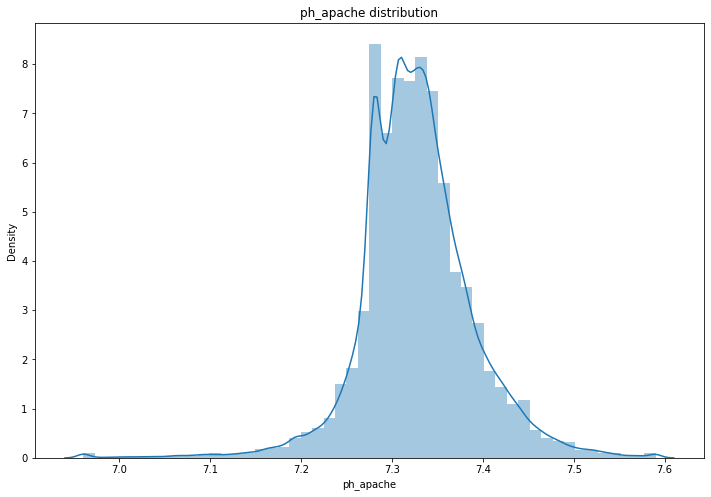

In [34]:
plt.figure (figsize = (12,8))
sns.distplot(X_train['ph_apache'])
plt.xlabel('ph_apache')
plt.title ('ph_apache distribution')

In [35]:
X_train['ph_apache'].isnull().sum()

0

In [36]:
# for x in mode_cols:
#     X_train[x].fillna(X_train[x].mode()[0], inplace = True) # Do I need to use mode()[0] ?!?!?!

In [37]:
h = missing_values_table(X_train)
print(h.to_markdown())

|                               |   Missing Values |   % of Total Values |
|:------------------------------|-----------------:|--------------------:|
| fio2_apache                   |                0 |                   0 |
| gcs_eyes_apache               |                0 |                   0 |
| gcs_motor_apache              |                0 |                   0 |
| gcs_verbal_apache             |                0 |                   0 |
| ph_apache                     |                0 |                   0 |
| ventilated_apache             |                0 |                   0 |
| d1_mbp_invasive_min           |                0 |                   0 |
| d1_spo2_min                   |                0 |                   0 |
| d1_sysbp_invasive_min         |                0 |                   0 |
| d1_sysbp_min                  |                0 |                   0 |
| d1_sysbp_noninvasive_min      |                0 |                   0 |
| d1_temp_min            

## Scaling

In [38]:
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train2, columns =X_test.columns)

In [39]:
X_test2 = sc.transform(X_test)
X_test = pd.DataFrame(X_test2, columns =X_train.columns)

In [40]:
X_train

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,1.341196,0.566113,0.411768,0.651014,0.393106,-0.693923,1.715811,0.650692,1.236873,1.261114,...,0.096614,0.253782,-0.681118,-0.680167,-0.362338,-0.354996,0.361934,-0.084662,0.132435,0.141210
1,0.132396,-0.492142,0.411768,-0.638808,0.126524,-0.693923,-0.755044,0.849586,-1.181828,-1.497119,...,6.575450,7.974038,-1.508991,-1.507935,5.096087,5.156082,-0.948045,-1.393921,0.105591,0.170133
2,0.172689,0.566113,0.411768,0.651014,0.206499,-0.693923,0.284101,0.252905,0.398390,-0.287368,...,0.096614,0.253782,1.871492,1.872118,0.048558,-0.005641,-0.534367,-0.309385,-0.001784,0.112288
3,-0.673471,0.566113,-0.371285,0.006103,1.646039,-0.693923,-1.586359,-0.045435,-1.584944,-1.351949,...,0.417638,-0.680342,-0.681118,-0.680167,0.362136,0.376466,-1.499615,-1.354839,0.320342,0.285823
4,0.636062,0.566113,0.411768,0.651014,0.345121,-0.693923,-0.039189,0.352352,0.172645,-0.287368,...,-0.448152,-0.405599,-1.508991,-1.507935,0.156688,0.169037,-0.350511,-0.084662,0.105591,0.170133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,-0.069071,0.566113,0.411768,0.651014,-0.182710,1.445797,0.353377,0.750139,0.688634,0.293313,...,-0.370329,-0.735290,0.077766,0.078620,-1.073836,-1.095192,-0.630892,0.120521,0.025060,0.112288
73366,-0.069071,0.566113,0.411768,0.006103,-0.268016,-0.693923,0.214825,0.054012,0.237143,0.244923,...,0.096614,0.253782,-0.750107,-0.749148,0.135062,0.147202,0.063167,-0.372894,0.266654,0.170133
73367,-0.210098,0.566113,0.411768,0.651014,0.686346,-0.693923,1.808180,0.054012,2.720342,1.503064,...,0.096614,0.253782,0.629682,0.630466,0.329697,0.343714,0.430881,0.355015,0.025060,0.112288
73368,2.348529,0.566113,0.411768,0.651014,-5.862925,1.445797,0.422654,-0.841009,0.156520,-0.480928,...,-0.525976,-0.542970,0.560692,0.561485,-0.232581,-0.223988,-2.326971,-0.475485,0.105591,0.199055


In [41]:
X_test

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,-1.600218,-0.492142,0.411768,0.651014,2.040580,-0.693923,0.330285,-0.045435,0.027523,-0.093808,...,-0.642712,-0.570445,0.905639,0.906389,-0.556972,-0.551508,2.062609,1.722898,0.051904,0.141210
1,-0.673471,-0.139390,0.411768,0.436044,1.006244,-0.693923,0.122456,0.352352,0.785382,1.406284,...,0.096614,0.253782,0.767661,0.768427,0.005306,0.016194,0.752630,1.185516,0.087695,0.160492
2,1.139729,0.566113,0.411768,0.651014,-1.030440,-0.693923,0.145548,0.949033,1.510992,-1.690680,...,-0.350873,-0.433074,0.146756,0.147601,-0.641314,-0.636663,0.072360,1.674045,0.132435,0.199055
3,-2.426231,0.566113,0.411768,0.651014,0.206499,-0.693923,0.953772,0.750139,1.478743,0.922383,...,-0.638821,-0.564950,1.526544,1.527215,-0.686729,-0.682516,0.247024,0.413639,-2.686164,-2.779962
4,-0.915231,0.566113,0.411768,-1.283718,0.057213,-0.693923,-1.932741,-0.443222,-1.794565,-1.158389,...,1.711459,1.902235,0.077766,0.078620,0.481080,0.496557,-0.171250,1.249025,0.374029,0.285823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18338,0.132396,-2.608651,-3.503496,-1.928629,2.104560,1.445797,-0.477938,0.451799,-0.214348,-0.045418,...,-0.837272,-0.845187,-0.612128,-0.611186,-0.578599,-0.617012,1.327182,-0.197023,1.367250,1.153498
18339,1.139729,0.566113,0.411768,-0.638808,1.901958,1.445797,-0.131557,-1.437689,-0.230472,-2.368140,...,1.322340,-0.350651,0.491703,0.492505,1.367749,1.391780,1.754649,0.941251,0.347186,0.401513
18340,0.656209,0.566113,0.411768,0.651014,1.283488,-0.693923,-0.154649,0.054012,0.285517,-0.771269,...,-0.234137,0.006514,0.077766,0.078620,-0.946242,-0.944533,1.350164,2.318905,0.186123,0.227978
18341,-0.069071,0.566113,0.411768,0.651014,1.539407,-0.693923,0.953772,0.153459,0.527387,1.890184,...,0.283392,0.737328,-0.267181,-0.266283,-0.807835,-0.804791,0.748034,1.776637,0.320342,0.256900


## Modelling

In [42]:
logreg = LogisticRegression(random_state=42)

In [43]:
knn = KNeighborsClassifier(n_neighbors=3)

In [44]:
svclass = svm.SVC(kernel = 'rbf', random_state=42)

In [45]:
gnb = GaussianNB()

In [46]:
rfc = RandomForestClassifier(random_state=42)

In [47]:
gbc = GradientBoostingClassifier (random_state=42)

In [48]:
xgbclass = xgb.XGBClassifier(random_state=42)

In [49]:
bgclassifier = BaggingClassifier(base_estimator=knn, n_estimators=100,
                                 max_features=10,
                                 max_samples=100,
                                 random_state= 42, n_jobs=-1)

## SMOTE

In [50]:
y2 = hospital_train['hospital_death'] #Target variable
X_sm = X.copy(deep = True) #Predictor matrix

smote = SMOTE(random_state=42)

In [51]:
X2 = imputer.fit_transform(X_sm)
X_sm = pd.DataFrame(X2, columns =X.columns)
X_sm

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0.700000,3.000000,6.0,4.0,7.306667,0.0,40.000000,74.0,64.000000,73.0,...,1.300000,1.000000,2.933333,2.933333,1.200000,1.200000,7.350000,7.303333,0.100000,0.050000
1,1.000000,1.000000,3.0,1.0,7.450000,1.0,58.000000,70.0,64.333333,67.0,...,3.500000,3.500000,1.966667,1.966667,3.500000,3.500000,7.450000,7.450000,0.470000,0.290000
2,0.553333,3.000000,6.0,5.0,7.303333,0.0,69.333333,91.0,91.666667,105.0,...,2.600000,2.333333,3.900000,3.900000,2.973333,2.973333,7.350000,7.370000,0.000000,0.000000
3,0.600000,4.000000,6.0,5.0,7.390000,1.0,52.000000,95.0,78.000000,84.0,...,2.933333,2.400000,3.600000,3.600000,1.300000,1.300000,7.340000,7.370000,0.040000,0.030000
4,0.570000,3.666667,6.0,5.0,7.280000,0.0,91.666667,96.0,128.666667,120.0,...,2.166667,2.033333,2.800000,2.800000,2.133333,2.133333,7.345000,7.321333,-0.656667,-0.663333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,0.463333,4.000000,6.0,5.0,7.333000,1.0,59.333333,85.0,80.333333,67.0,...,2.666667,1.400000,2.733333,2.733333,2.466667,2.466667,7.340000,7.340000,0.120000,0.050000
91709,0.566667,4.000000,6.0,5.0,7.290000,0.0,30.000000,45.0,81.000000,65.0,...,1.400000,1.400000,2.866667,2.866667,1.133333,1.133333,7.150000,7.313333,0.030000,0.020000
91710,0.900000,3.000000,6.0,4.0,7.310000,0.0,57.666667,81.0,89.333333,75.0,...,2.600000,2.333333,2.500000,2.500000,2.006667,2.006667,6.930000,6.930000,0.050000,0.020000
91711,0.666667,4.000000,5.0,4.0,7.313333,0.0,94.666667,83.0,106.000000,111.0,...,2.600000,2.333333,3.133333,3.133333,2.000000,2.000000,7.370000,7.313333,0.070000,0.020000


In [52]:
X2 = imputer.fit_transform(X_test)
X_test = pd.DataFrame(X2, columns =X_train.columns)
X_test

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,-1.600218,-0.492142,0.411768,0.651014,2.040580,-0.693923,0.330285,-0.045435,0.027523,-0.093808,...,-0.642712,-0.570445,0.905639,0.906389,-0.556972,-0.551508,2.062609,1.722898,0.051904,0.141210
1,-0.673471,-0.139390,0.411768,0.436044,1.006244,-0.693923,0.122456,0.352352,0.785382,1.406284,...,0.096614,0.253782,0.767661,0.768427,0.005306,0.016194,0.752630,1.185516,0.087695,0.160492
2,1.139729,0.566113,0.411768,0.651014,-1.030440,-0.693923,0.145548,0.949033,1.510992,-1.690680,...,-0.350873,-0.433074,0.146756,0.147601,-0.641314,-0.636663,0.072360,1.674045,0.132435,0.199055
3,-2.426231,0.566113,0.411768,0.651014,0.206499,-0.693923,0.953772,0.750139,1.478743,0.922383,...,-0.638821,-0.564950,1.526544,1.527215,-0.686729,-0.682516,0.247024,0.413639,-2.686164,-2.779962
4,-0.915231,0.566113,0.411768,-1.283718,0.057213,-0.693923,-1.932741,-0.443222,-1.794565,-1.158389,...,1.711459,1.902235,0.077766,0.078620,0.481080,0.496557,-0.171250,1.249025,0.374029,0.285823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18338,0.132396,-2.608651,-3.503496,-1.928629,2.104560,1.445797,-0.477938,0.451799,-0.214348,-0.045418,...,-0.837272,-0.845187,-0.612128,-0.611186,-0.578599,-0.617012,1.327182,-0.197023,1.367250,1.153498
18339,1.139729,0.566113,0.411768,-0.638808,1.901958,1.445797,-0.131557,-1.437689,-0.230472,-2.368140,...,1.322340,-0.350651,0.491703,0.492505,1.367749,1.391780,1.754649,0.941251,0.347186,0.401513
18340,0.656209,0.566113,0.411768,0.651014,1.283488,-0.693923,-0.154649,0.054012,0.285517,-0.771269,...,-0.234137,0.006514,0.077766,0.078620,-0.946242,-0.944533,1.350164,2.318905,0.186123,0.227978
18341,-0.069071,0.566113,0.411768,0.651014,1.539407,-0.693923,0.953772,0.153459,0.527387,1.890184,...,0.283392,0.737328,-0.267181,-0.266283,-0.807835,-0.804791,0.748034,1.776637,0.320342,0.256900


In [53]:
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_sm, y2)
X_train, X_test, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.20, random_state=42) #train test split

print('Original dataset shape', collections.Counter(y))
print('Resample dataset shape', collections.Counter(y_smote))

Original dataset shape Counter({0: 83798, 1: 7915})
Resample dataset shape Counter({0: 83798, 1: 83798})


#### Choosing best features

In [54]:
X_train_smote = X_train[corr_short.index.tolist()] #Training predictor matrix
X_test_smote = X_test[corr_short.index.tolist()] #Testing predictor matrix

In [55]:
X_train_smote.shape, X_test_smote.shape

((134076, 23), (33520, 23))

In [56]:
sc = StandardScaler()
X_train4 = sc.fit_transform(X_train_smote)
X_train_smote = pd.DataFrame(X_train4, columns =X_test_smote.columns)

In [57]:
X_test4 = sc.transform(X_test_smote)
X_test_smote = pd.DataFrame(X_test4, columns =X_train_smote.columns)

**Note**: Converting the test and train into dataframes above

## Modelling - SMOTE

### Stacking Classifier

In [58]:
estimators = [
    ('logreg', logreg),
    ('knn', knn),
    ('gbc', gbc),
    ('xgb', xgbclass)]

#Final estimator definition
final_estimator = rfc

stackclass = StackingClassifier(estimators=estimators, final_estimator=final_estimator, n_jobs = -1)

In [59]:
stackclass.fit(X_train_smote, y_train_smote)

StackingClassifier(estimators=[('logreg', LogisticRegression(random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('gbc',
                                GradientBoostingClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              gamma=None, gpu_id=None,
                                              importance_...
                                              max_depth=None,
                                              min_child_weight=None,
                                              missing=nan,
        

In [60]:
score_test = stackclass.score(X_test_smote, y_test_smote)
score_train = stackclass.score(X_train_smote, y_train_smote)
print (score_train, score_test)

0.9849488349891107 0.9622613365155132


**Insights**: Very good!

In [61]:
y_pred = stackclass.predict(X_test_smote)

In [62]:
con_mat_array = confusion_matrix(y_test_smote, y_pred)
con_mat_array

array([[16135,   539],
       [  726, 16120]], dtype=int64)

In [63]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test_smote, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.96      0.97      0.96     16674
     class 1       0.97      0.96      0.96     16846

    accuracy                           0.96     33520
   macro avg       0.96      0.96      0.96     33520
weighted avg       0.96      0.96      0.96     33520



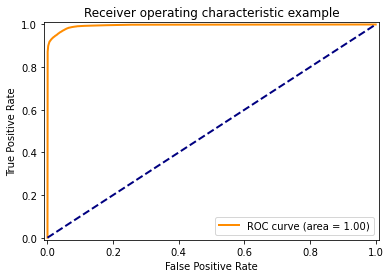

In [64]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = stackclass.predict_proba(X_test_smote)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test_smote, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [65]:
# train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(stackclass, X_train_smote, y_train_smote, cv=15,return_times=True, n_jobs = -1)

# plt.figure (figsize = (12,8))
# plt.plot(train_sizes,np.mean(train_scores,axis=1), label = 'Training accuracy', marker = 'o')
# plt.plot(train_sizes,np.mean(test_scores,axis=1), label = 'Test accuracy', marker = 'x')
# # plt.ylim ([0.75, 1])
# plt.xlabel('Data size')
# plt.ylabel('Score')
# plt.title('Naive Bayes learning curve')
# plt.grid()
# plt.legend(loc="lower right")

**Note**: I had to comment out the code above because it was locking up my laptop :(

In [82]:
stackclass.estimators_

[LogisticRegression(random_state=42),
 KNeighborsClassifier(n_neighbors=3),
 GradientBoostingClassifier(random_state=42),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=12,
               num_parallel_tree=1, predictor='auto', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)]

In [87]:
stackclass.named_estimators_

{'logreg': LogisticRegression(random_state=42),
 'knn': KNeighborsClassifier(n_neighbors=3),
 'gbc': GradientBoostingClassifier(random_state=42),
 'xgb': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=12,
               num_parallel_tree=1, predictor='auto', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)}

**Note**: I was going to try the code below to extract the feature importances by my learners all have different methods. I will come back to this later if I have time.

In [102]:
# feat_impts = [] 
# for clf in multi_forest.estimators_:
#     feat_impts.append(clf.feature_importances_)

# np.mean(feat_impts, axis=0)

## Testing

In [66]:
 testing_set = hospital_test[corr_short.index.tolist()] #Using the unknown data to test stuff

In [67]:
X5 = imputer.fit_transform(testing_set)
testing_set = pd.DataFrame(X5, columns = X_train.columns)
testing_set

,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,ph_apache,ventilated_apache,d1_mbp_invasive_min,d1_spo2_min,d1_sysbp_invasive_min,d1_sysbp_min,...,d1_lactate_max,d1_lactate_min,h1_albumin_max,h1_albumin_min,h1_lactate_max,h1_lactate_min,d1_arterial_ph_min,h1_arterial_ph_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
0,0.370000,2.0,5.0,1.0,7.450000,0.0,61.666667,96.0,85.333333,79.0,...,2.033333,1.933333,3.366667,3.366667,1.766667,1.766667,7.382333,7.382333,0.13,0.08
1,0.320000,4.0,6.0,4.0,7.326667,0.0,62.000000,90.0,96.000000,83.0,...,1.686667,1.556667,3.166667,3.166667,1.420000,1.420000,7.422000,7.349667,0.09,0.03
2,0.326667,2.0,5.0,1.0,7.416667,0.0,71.000000,95.0,102.000000,102.0,...,1.600000,1.566667,3.400000,3.400000,2.440000,2.440000,7.416667,7.429667,0.03,0.02
3,0.700000,4.0,6.0,1.0,7.350000,1.0,59.000000,92.0,81.000000,69.0,...,0.800000,0.800000,1.900000,1.900000,1.966667,1.600000,7.350000,7.397667,0.19,0.17
4,0.370000,1.0,4.0,1.0,7.330333,1.0,37.000000,95.0,66.000000,66.0,...,5.933333,5.766667,3.300000,3.300000,5.933333,5.933333,7.291667,7.351667,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39303,0.623333,3.0,6.0,5.0,7.433333,0.0,74.000000,92.0,88.000000,94.0,...,1.300000,1.300000,3.566667,3.566667,1.566667,1.566667,7.423000,7.433667,0.01,0.00
39304,0.583333,4.0,6.0,4.0,7.382333,1.0,68.666667,94.0,100.000000,95.0,...,3.500000,3.500000,3.466667,3.466667,2.900000,2.733333,7.358000,7.367667,0.08,0.05
39305,0.566667,4.0,6.0,5.0,7.409667,0.0,82.000000,100.0,86.000000,89.0,...,5.000000,1.700000,2.500000,2.500000,3.436667,3.436667,7.388000,7.391667,0.13,0.05
39306,0.336667,4.0,6.0,5.0,7.440333,0.0,52.333333,90.0,97.000000,111.0,...,1.200000,1.200000,3.166667,3.166667,0.900000,0.900000,7.460333,7.396667,0.04,0.02


In [68]:
testing_set_2 = sc.transform(testing_set)
testing_set = pd.DataFrame(testing_set_2, columns =X_train.columns)

In [69]:
y_pred_testing = stackclass.predict(testing_set)
y_pred_testing

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [70]:
probs_testing = stackclass.predict_proba(testing_set)

In [71]:
print('Break down of the classes', collections.Counter(y_pred_testing), 'Percentage of class 0 = ', 1-(collections.Counter(y_pred_testing)[1]/collections.Counter(y_pred_testing)[0]))

Break down of the classes Counter({0: 36209, 1: 3099}) Percentage of class 0 =  0.9144135435941341


In [72]:
probs_testing[:,0]

array([1.  , 1.  , 0.98, ..., 0.94, 1.  , 1.  ])

In [73]:
probabilities = pd.DataFrame(data=probs_testing, index=None, columns=['Probability of 0', 'Probability of 1'])

In [74]:
probabilities.head()

,Probability of 0,Probability of 1
0,1.00,0.00
1,1.00,0.00
2,0.98,0.02
3,1.00,0.00
4,1.00,0.00


In [75]:
probabilities.shape

(39308, 2)

In [76]:
type(y_pred_testing)

numpy.ndarray

In [77]:
probabilities['Prediction'] = y_pred_testing.tolist()

In [78]:
probabilities.head()

,Probability of 0,Probability of 1,Prediction
0,1.00,0.00,0
1,1.00,0.00,0
2,0.98,0.02,0
3,1.00,0.00,0
4,1.00,0.00,0


In [79]:
probabilities.shape

(39308, 3)

In [80]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

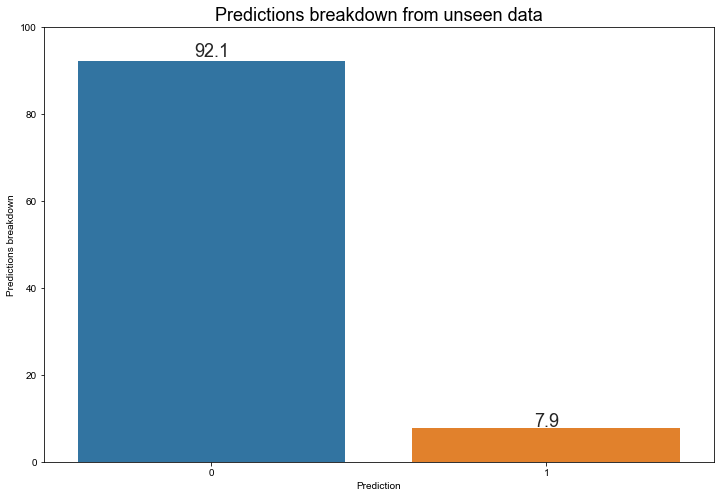

In [81]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Prediction", y="Prediction", data=probabilities, estimator=lambda x: len(x) / len(probabilities) * 100)
ax.set(ylabel="Predictions breakdown")
sns.set(font_scale=1.5)
ax.set(ylim = (0,100))
ax.set(title = 'Predictions breakdown from unseen data')
show_values(ax)

## Conclusion

The stacking classifier model produced a high accuracy and high recall algorithm. When tested on unseen data, the model produced desireable results (not just all zeroes, and thus it is a good model for this predictive problem. <br> Unfortunately, due to the way that stacking classifiers work, it is not readily possible to get feature importances for each weak learner. What I would need to do is to individually extract the coeff_ of the logistic regression, feature importances of KNN, etc.. in order to get feature importances. However, due to lack of time, this was not completed.

## PS

Below are the feature importances using the learners in my stacking model. 

In [115]:
stackclass.estimators_[0].coef_ #from LogisticRegression

array([[ 0.1299526 , -0.14597644, -0.11335712, -0.08598422,  0.10069561,
         0.37920031, -0.09188482, -0.34883603, -0.04683905, -0.13605785,
        -0.14140735, -0.20425132, -0.18269192,  0.09717643,  0.4352791 ,
        -0.03349324, -0.07184311, -0.15917749,  0.15587331, -0.07663078,
        -0.08583124,  1.17605637, -0.85999366]])

In [116]:
stackclass.estimators_[2].feature_importances_ #From Gradient Boosting Classifier

array([2.57941502e-02, 4.66126978e-02, 2.32974306e-02, 8.67865227e-02,
       5.09580891e-04, 2.23389386e-01, 4.06292065e-05, 2.41051227e-02,
       6.54292001e-04, 9.58598801e-03, 1.09933136e-03, 3.40349551e-02,
       1.50000294e-02, 3.98409932e-03, 2.58657057e-02, 7.59821642e-04,
       7.20009836e-04, 1.76307799e-04, 1.76556322e-03, 1.52929748e-02,
       1.70698321e-04, 8.61844737e-02, 3.74170230e-01])

In [117]:
stackclass.estimators_[3].feature_importances_ #From XGBoost

array([0.01885658, 0.10323807, 0.04914088, 0.09449643, 0.00609208,
       0.29459092, 0.0039744 , 0.01965601, 0.00386388, 0.00785201,
       0.01080245, 0.03146487, 0.01501086, 0.00900548, 0.01806076,
       0.00639032, 0.00885851, 0.00414586, 0.00301229, 0.01038582,
       0.00377333, 0.06801832, 0.20930988], dtype=float32)

### Most important features:
In no particular order:
- fio2_apache
- ph_apache
- verbal_apache
- venitlated_apache